In [1]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({"font.size": 16})

In [2]:
import numpy as np
import os
import datetime

In [3]:
import rompy as rp

In [4]:
import scrinet.workflow.generators

In [131]:
%%time
# generate training and test sets
M = 60
t_min = -1000
# t_min = -10000


q1_array = np.linspace(1, 10, 2)
(
    times,
    ts_amp,
    ts_phase,
    _,
    _,
    _,
    coords1,
) = scrinet.workflow.generators.gen_1d_massratio_data(
    q1_array, M, n_cores=2, t_min=t_min
)

q2_random = np.random.uniform(1, 10, 10)
(
    _,
    ts2_amp,
    ts2_phase,
    _,
    _,
    _,
    coords2,
) = scrinet.workflow.generators.gen_1d_massratio_data(
    q2_random, M, n_cores=4, t_min=t_min
)

q3_random = np.random.uniform(1, 10, 10)
(
    _,
    ts3_amp,
    ts3_phase,
    _,
    _,
    _,
    coords3,
) = scrinet.workflow.generators.gen_1d_massratio_data(
    q3_random, M, n_cores=4, t_min=t_min
)


q4_random = np.random.uniform(1, 10, 100)
(
    _,
    ts4_amp,
    ts4_phase,
    _,
    _,
    _,
    coords4,
) = scrinet.workflow.generators.gen_1d_massratio_data(
    q4_random, M, n_cores=4, t_min=t_min
)


q5_random = np.random.uniform(10, 20, 100)
(
    _,
    ts5_amp,
    ts5_phase,
    _,
    _,
    _,
    coords5,
) = scrinet.workflow.generators.gen_1d_massratio_data(
    q5_random, M, n_cores=4, t_min=t_min
)

# # q6_random = np.random.uniform(1, 20, 1000)
# # (
# #     _,
# #     ts6_amp,
# #     ts6_phase,
# #     _,
# #     _,
# #     _,
# #     coords6,
# # ) = scrinet.workflow.generators.gen_1d_massratio_data(
# #     q6_random, M, n_cores=4, t_min=t_min
# # )

CPU times: user 350 ms, sys: 243 ms, total: 593 ms
Wall time: 1min 14s


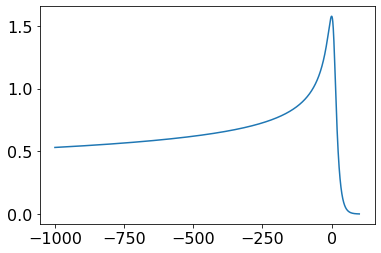

In [132]:
plt.figure()
plt.plot(times, ts_amp[0])

In [133]:
coords4.shape

(100, 1)

Text(0.5, 0, 'mass-ratio')

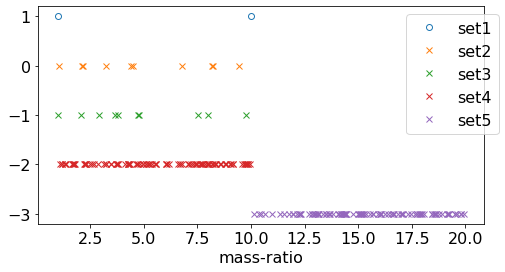

In [134]:
plt.figure(figsize=(8,4))
plt.plot(coords1, np.ones_like(coords1), "o", markerfacecolor="None", label='set1')
plt.plot(coords2, np.ones_like(coords2)-1, "x", label='set2')
plt.plot(coords3, np.ones_like(coords3)-2, "x", label='set3')
plt.plot(coords4, np.ones_like(coords4)-3, "x", label='set4')
plt.plot(coords5, np.ones_like(coords5)-4, "x", label='set5')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel("mass-ratio")

In [135]:
integration = rp.Integration([times[0], times[-1]], len(times), rule="trapezoidal")

In [136]:
class GreedyReducedBasis(rp.greedy._ReducedBasis, rp.greedy._IteratedModifiedGramSchmidt):
    def __init__(self, inner):
        """
        inner: integration rule. Instance of rompy.Integration.
        """
        
        self.inner = inner
        rp.greedy._ReducedBasis.__init__(self, inner)
        rp.greedy._IteratedModifiedGramSchmidt.__init__(self, inner)
        
        # this is an L2 loss
        self.loss = self.proj_errors_from_alpha
        
    def load_basis(self, filename):
        self.basis = np.load(filename)
        self.size = len(self.basis)
        
    def compute_training_set_norms(self, ts):
        """compute the norm of all elements in training set
        returns array of len(training_set)
        """
        return np.array([self.inner.norm(tt) for tt in ts])
        
    def iteration(self, step, errs, ts, ext_idx=None):
        """one iteration of reduced basis greedy algorithm
        
        returns 1 if index already selected
        else it doesn't return anything (returns None) and modifies
        self.indices, self.errors, self.basis and self.alphas
        """
        next_index = np.argmax(errs)
        if next_index in self.indices:
            print(">> Warning(Index already selected): Exiting greedy algorithm", flush=True)
            return 1
        else:
            idx = step+1
            if ext_idx:
                ext_idx = ext_idx+1
            else:
                ext_idx = idx
                
#             print(f"idx: {idx} \t ext_idx: {ext_idx}")
            self.indices[idx] = next_index
            self.errors[idx] = errs[next_index]
            self.basis[ext_idx], _ = self.add_basis(ts[next_index], self.basis[:ext_idx])
            self.alphas[ext_idx] = self.alpha_arr(self.basis[ext_idx], ts)
        
    def make(self, ts, tol, seed_index, num=None):
        """make initial basis
        """

        # Npoints: length of training set
        # Nsamples: number of samples per training set element. e.g. number of time samples
        # Nbasis: max number of basis elements, defaults to len(ts)
        Npoints, Nsamples = ts.shape
        
        if num is None:
            Nbasis = len(ts)
        else:
            assert type(num) is int, "Expecting integer."
            assert num >= 0, "Requested number of basis vectors must be non-negative."
            Nbasis = num
        
        # allocate memory for arrays
        # could modify to work with complex data...
        self.errors = np.zeros(Nbasis, dtype=np.float64)
        # initialising indices to -1 to safe guard against
        # checking if next_index is already in self.indices
        self.indices = np.zeros(Nbasis, dtype=np.int32) - 1
        self.basis = np.zeros((Nbasis, Nsamples), dtype=np.float64)
        self.alphas = np.zeros((Nbasis, Npoints), dtype=np.float64)
        
        # pre-compute training set norms
        ts_norms = self.compute_training_set_norms(ts)
        
        # pick element to seed greedy algorithm
        self.indices[0] = seed_index
        self.basis[0] = ts[seed_index] / ts_norms[seed_index]
        self.alphas[0] = self.alpha_arr(self.basis[0], ts)
        # only true for L2 norm. But not sure why...
        self.errors[0] = np.max(ts_norms)**2
        
        # loop over all elements in the training set except for the seed_index
        print("\nStep \t Error", flush=True)
        step = 0
        flag = 0
        while step < Nbasis:
            print(f"{step + 1} \t {self.errors[step]}", flush=True)
            
            # check if tolerance is met
            if self.errors[step] <= tol:
                if step == 0:
                    step += 1
                break
            # of if the number of basis vectors has been reached
            elif step == Nbasis-1:
                step += 1
                break
            # otherwise, add another point and basis vector
            else:
                # first compute the projection errors of the current basis
                # [:step+1] selects all alphas upto the current step.
                # this loss function could be trivially parallelised
                errs = self.loss(self.alphas[:step+1], norms=ts_norms)
                # then pass the errors into the `iteration` method
                # which will pick the case with the largest error and add it to the basis via IMGS.
                flag = self.iteration(step, errs, ts)
                
            # if previously selected index selected again then exit
            if flag == 1:
                step += 1
                break
            # otherwise, increment counter
            step += 1
            
        self.size = step
        self.indices = self.indices[:self.size]
        self.errors = self.errors[:self.size]
        self.basis = self.basis[:self.size]
        self.alphas = self.alphas[:self.size]
        
    def validate(self, ts):
        """validate basis.
        compute basis representation error against training set (ts) and record cases with error > tol.
        """
        # compute errors
        # this loop can be trivially parallelised
        validation_errors = np.array([self.proj_error_from_basis(self.basis, tt) for tt in ts])
        return validation_errors

    def enrich(self, ts, tol, num=None):
        """enrich basis (add training set (ts) to basis.)
        """
        # Npoints: length of training set
        # Nsamples: number of samples per training set element. e.g. number of time samples
        # Nbasis: max number of basis elements, defaults to len(ts)
        Npoints, Nsamples = ts.shape
        
        if num is None:
            Nbasis = len(ts)
        else:
            assert type(num) is int, "Expecting integer."
            assert num >= 0, "Requested number of basis vectors must be non-negative."
            Nbasis = num
        
        # allocate memory for arrays
        # could modify to work with complex data...
        self.errors = np.zeros(Nbasis, dtype=np.float64)
        # initialising indices to -1 to safe guard against
        # checking if next_index is already in self.indices
        self.indices = np.zeros(Nbasis, dtype=np.int32) - 1
        
        # project training set onto current basis
        current_alphas = np.array([self.alpha_arr(bb, ts) for bb in self.basis])
        
        # extend basis and alpha array storage
        basis_extension = np.zeros((Nbasis, Nsamples), dtype=np.float64)
        self.basis = np.row_stack((self.basis, basis_extension))
        
        alpha_extension = np.zeros((Nbasis, Npoints), dtype=np.float64)
        self.alphas = np.row_stack((current_alphas, alpha_extension))
        
#         print("extended arrays")
#         print(self.basis.shape)
#         print(self.alphas.shape)
        
        # pre-compute training set norms
        ts_norms = self.compute_training_set_norms(ts)
                
        # idx is the first index in the extended basis
        # (because python arrays start at indexing at zero)
        idx = self.size
        
#         self.errors[0] = np.max(self.loss(self.alphas[:idx+1], norms=ts_norms))
        
        # loop over max number of possible number of basis vectors to add.
        print("\nStep \t Error", flush=True)
        for step in range(-1, Nbasis-1):
            
            # index for extended arrays
            ext_idx = idx + step
#             print(f"pre iter ext_idx: {ext_idx}")
            errs = self.loss(self.alphas[:ext_idx+1], norms=ts_norms)
            flag = self.iteration(step, errs, ts, ext_idx=ext_idx)
            if flag == 1:
                break
            if self.errors[step+1] <= tol:
                print("tolerance met. exiting")
                break
            print(f"{step + 1} \t {self.errors[step+1]}", flush=True)
            
        self.size = ext_idx+2
        self.indices = self.indices[:step+2]
        self.errors = self.errors[:step+2]
        self.basis = self.basis[:self.size]
        self.alphas = self.alphas[:self.size]

In [137]:
grb = GreedyReducedBasis(integration)

In [138]:
ts_amp.shape

(2, 5000)

In [139]:
grb.make(ts_amp, 1e-12, 0)
# grb.make(ts2_amp, 1e-12, 1)


Step 	 Error
1 	 626.824329838654
2 	 2.952149422757657


In [140]:
# grb = GreedyReducedBasis(integration)
# np.save("test_basis.npy", grb.basis)
# grb.load_basis("test_basis.npy")

In [141]:
step1_training_set = ts_amp[grb.indices]

In [142]:
grb.errors

array([626.82432984,   2.95214942])

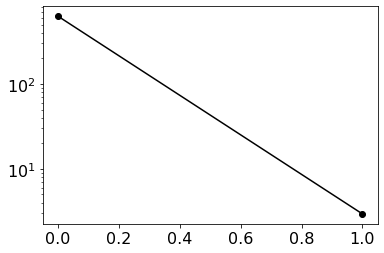

In [143]:
plt.figure()
plt.plot(grb.errors, 'k-o')
plt.yscale('log')

In [144]:
grb.indices

array([0, 1], dtype=int32)

In [145]:
grb.alphas.shape

(2, 2)

In [146]:
grb.alphas[0]

array([23.1900075 , 24.97743342])

In [147]:
grb.alpha_arr(grb.basis[0], ts_amp)

array([23.1900075 , 24.97743342])

In [148]:
grb.alpha_arr(grb.basis[0], ts2_amp)

array([23.19047175, 23.32365537, 24.66404292, 23.86039657, 24.88919337,
       24.39224228, 24.67601945, 23.57949683, 23.89192199, 23.32926734])

In [149]:
grb.proj_error_from_basis(grb.basis, ts_amp[0])

0.0

In [150]:
grb.proj_error_from_basis(grb.basis, ts2_amp[0])

0.00011809148418251425

In [151]:
grb.validate(ts_amp)

array([0., 0.])

In [152]:
grb.validate(ts2_amp)

array([0.00011809, 0.00441487, 0.00180458, 0.00368124, 0.00037611,
       0.00125298, 0.0005918 , 0.00587565, 0.00392606, 0.00318169])

In [153]:
grb.validate(ts2_amp)

array([0.00011809, 0.00441487, 0.00180458, 0.00368124, 0.00037611,
       0.00125298, 0.0005918 , 0.00587565, 0.00392606, 0.00318169])

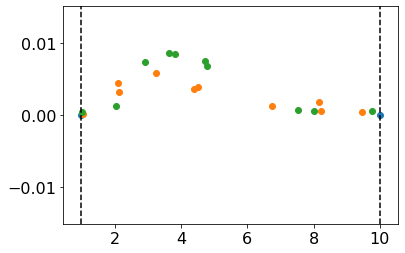

In [154]:
plt.figure()
plt.axvline(coords1[0], ls='--', color='k')
plt.axvline(coords1[1], ls='--', color='k')
plt.scatter(coords1, grb.validate(ts_amp))
plt.scatter(coords2, grb.validate(ts2_amp))
plt.scatter(coords3, grb.validate(ts3_amp))
# plt.yscale('log')

Text(0.5, 0, 'mass-ratio')

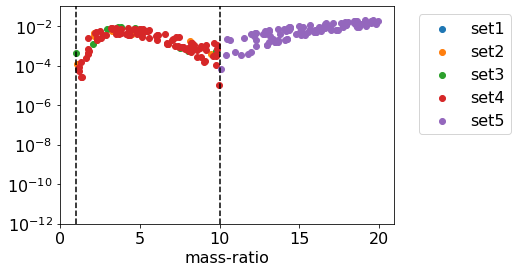

In [155]:
plt.figure()
plt.axvline(coords1[0], ls='--', color='k')
plt.axvline(coords1[1], ls='--', color='k')
plt.scatter(coords1, grb.validate(ts_amp), label='set1')
plt.scatter(coords2, grb.validate(ts2_amp), label='set2')
plt.scatter(coords3, grb.validate(ts3_amp), label='set3')
plt.scatter(coords4, grb.validate(ts4_amp), label='set4')
plt.scatter(coords5, grb.validate(ts5_amp), label='set5')
plt.yscale('log')
plt.ylim(1e-12, 1e-1)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel("mass-ratio")

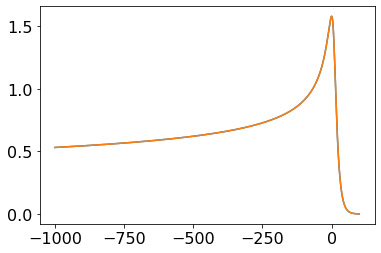

In [156]:
plt.figure()
plt.plot(times, ts2_amp[0])
plt.plot(times, grb.projection_from_basis(ts2_amp[0], grb.basis))

In [157]:
ts2_amp.shape

(10, 5000)

In [158]:
grb.basis.shape

(2, 5000)

In [159]:
# grb.enrich(ts=ts2_amp, tol=1e-12, num=3)
grb.enrich(ts=ts2_amp, tol=1e-12)


Step 	 Error
0 	 0.005875649880408673
1 	 0.0008313683659935123
2 	 3.4365643500677834e-05
3 	 7.705874963903625e-06
4 	 2.03158072054066e-06
5 	 3.764766915992368e-07
6 	 3.3753281059034634e-08
7 	 7.872358764871024e-09
8 	 4.171852197032422e-09
9 	 4.1393377614440396e-10


In [160]:
grb.basis.shape

(12, 5000)

In [161]:
grb.indices.shape

(10,)

In [162]:
step2_training_set = ts2_amp[grb.indices]

In [163]:
step2_training_set.shape

(10, 5000)

In [164]:
grb.basis

array([[ 2.28919362e-02,  2.28930662e-02,  2.28941965e-02, ...,
         3.34737423e-05,  3.28468979e-05,  3.22307175e-05],
       [ 2.82677760e-02,  2.82660985e-02,  2.82644202e-02, ...,
        -1.34239654e-04, -1.32150237e-04, -1.30109876e-04],
       [-1.96366639e-02, -1.96318341e-02, -1.96270027e-02, ...,
        -1.02671786e-03, -1.01234043e-03, -9.98457027e-04],
       ...,
       [ 1.85095986e-02,  1.84993645e-02,  1.84890370e-02, ...,
        -1.53834967e-02, -1.78735923e-02, -2.05790675e-02],
       [-2.46313393e-02, -2.46568016e-02, -2.46825343e-02, ...,
         9.12190705e-03,  1.03179258e-02,  1.16139076e-02],
       [-3.48995105e-03, -3.46295258e-03, -3.43681095e-03, ...,
        -1.57543574e-02, -1.88506372e-02, -2.21984781e-02]])

In [165]:
grb.alphas

array([[ 2.31904718e+01,  2.33236554e+01,  2.46640429e+01,
         2.38603966e+01,  2.48891934e+01,  2.43922423e+01,
         2.46760194e+01,  2.35794968e+01,  2.38919220e+01,
         2.33292673e+01],
       [ 2.16873320e-03,  2.80102549e-01,  1.50850268e+00,
         8.88143076e-01,  1.66099828e+00,  1.30883363e+00,
         1.51410000e+00,  6.15185800e-01,  9.17265054e-01,
         2.86224440e-01],
       [ 8.46765141e-03,  6.40100293e-02,  4.17998492e-02,
         5.68856433e-02,  1.83305307e-02,  2.05331745e-02,
         2.28252688e-02,  7.66527878e-02,  5.97187917e-02,
         5.53517526e-02],
       [-6.43389209e-03, -1.75368522e-02, -4.79432689e-03,
         2.10478429e-02, -5.67894189e-03,  2.88334591e-02,
         8.02378648e-03,  4.44089210e-16,  1.89240436e-02,
        -1.04756954e-02],
       [ 1.72083605e-03,  1.56454246e-03,  5.86222171e-03,
        -1.15692756e-03,  2.80025645e-03, -3.33066907e-16,
         2.49952232e-03,  0.00000000e+00, -1.36066896e-04,
        -6.

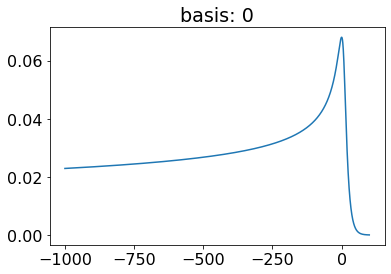

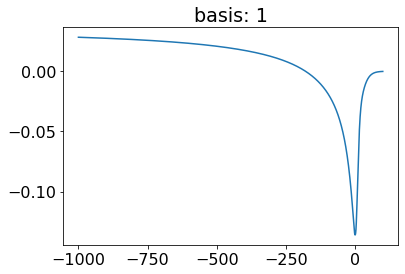

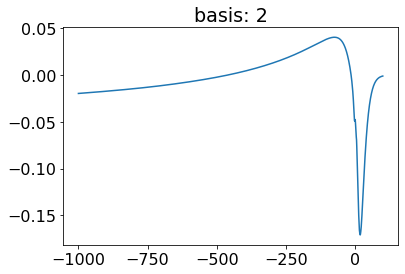

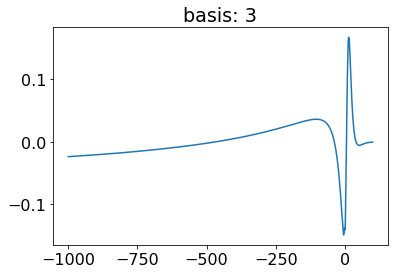

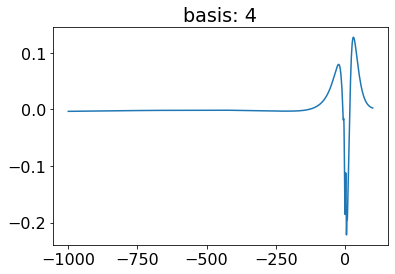

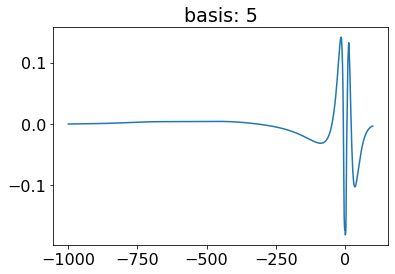

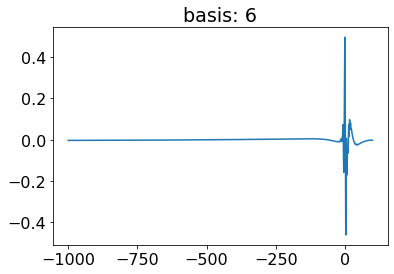

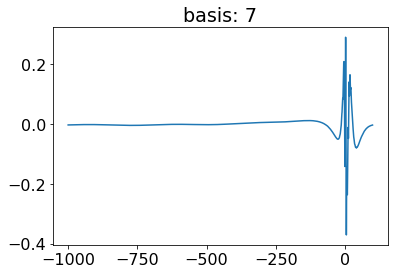

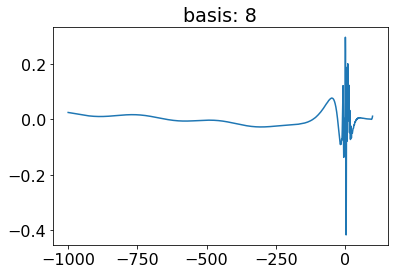

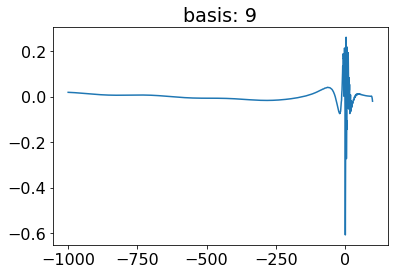

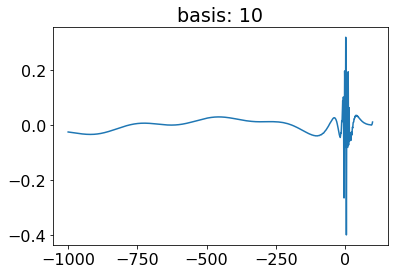

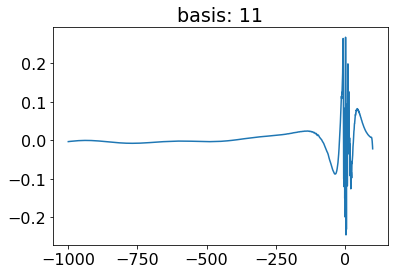

In [166]:
for i, bb in enumerate(grb.basis):
    plt.figure()
    plt.plot(times, bb)
    plt.title(f"basis: {i}")
#     plt.xlim(-100, 100)
    plt.show()
    plt.close()

In [167]:
grb.basis.shape

(12, 5000)

In [168]:
grb.validate(ts2_amp)

array([-1.13686838e-13,  2.27373675e-13,  1.13686838e-13, -1.13686838e-13,
        2.27373675e-13,  1.13686838e-13,  0.00000000e+00,  1.13686838e-13,
       -3.41060513e-13,  1.13686838e-13])

In [169]:
grb.validate(ts3_amp)

array([1.76449930e-08, 1.55068847e-09, 2.94369329e-09, 2.19423555e-08,
       2.38685516e-09, 1.52306256e-09, 4.86238605e-09, 5.08828180e-09,
       9.62393187e-09, 6.47037268e-09])

In [170]:
grb.validate(ts4_amp)

array([1.72792625e-09, 6.55177246e-10, 4.06703293e-09, 9.10290510e-10,
       9.95214577e-10, 9.00377017e-09, 1.16584715e-08, 4.98138206e-08,
       1.58992179e-08, 2.44142484e-09, 1.01977093e-09, 1.60397349e-08,
       4.87375473e-10, 1.11742793e-09, 2.45388492e-08, 7.62497621e-10,
       2.88013098e-08, 2.92659479e-08, 9.04435637e-09, 1.14896466e-08,
       1.71967258e-08, 9.68384484e-10, 1.34821221e-09, 5.63011326e-09,
       4.45425030e-10, 1.20300001e-08, 4.44424586e-09, 9.50876711e-10,
       7.44842055e-09, 3.12752491e-10, 1.13277565e-09, 3.26804184e-09,
       1.65745178e-08, 3.18630100e-09, 4.46357262e-09, 2.38892426e-08,
       2.75201728e-09, 9.91121851e-09, 3.75405307e-09, 1.06695097e-09,
       2.89412583e-09, 5.39023404e-09, 9.09835762e-09, 2.32944330e-10,
       1.29693944e-09, 1.86971647e-08, 1.01056230e-09, 1.55038151e-08,
       1.68469114e-08, 3.40924089e-09, 8.30834779e-09, 2.43755949e-09,
       3.37195161e-10, 2.40504505e-09, 4.62819116e-10, 3.37536221e-10,
      

In [171]:
grb.validate(ts5_amp)

array([2.74971251e-06, 1.10648216e-07, 5.57833800e-07, 1.42109798e-07,
       9.31481736e-09, 1.00323632e-07, 9.97994221e-07, 2.55854502e-08,
       2.45126989e-06, 1.69889086e-06, 8.02954332e-07, 1.65825895e-07,
       1.97953796e-08, 1.54728923e-08, 2.21995151e-08, 8.74194939e-09,
       9.17223247e-07, 1.61530318e-06, 4.39211703e-07, 1.35521191e-06,
       7.91931143e-09, 4.67775067e-07, 2.67260702e-08, 1.49959169e-06,
       3.76821049e-07, 1.78004018e-06, 2.41381042e-06, 6.83674784e-07,
       1.61733055e-07, 6.16768148e-08, 8.14102918e-07, 3.13466933e-06,
       1.54207203e-06, 1.25035365e-06, 1.82606755e-07, 2.50456048e-06,
       7.69182407e-09, 8.38913138e-07, 3.33131538e-07, 6.62682623e-07,
       1.06667812e-08, 1.28016268e-07, 3.05287472e-07, 1.28157467e-07,
       2.57664169e-07, 4.35481752e-07, 5.78934760e-07, 5.77070978e-08,
       1.76887625e-08, 1.47008222e-06, 2.20927632e-08, 2.52337031e-08,
       9.09760274e-07, 1.35615846e-06, 3.52814516e-06, 5.55825181e-08,
      

In [172]:
ts4_amp.shape

(100, 5000)

In [173]:
grb.basis.shape

(12, 5000)

In [174]:
# grb = GreedyReducedBasis(integration)
# # np.save("test_basis_2.npy", grb.basis)
# grb.load_basis("test_basis_2.npy")

In [175]:
grb.enrich(ts=ts4_amp, tol=1e-12)


Step 	 Error
0 	 4.981382062396733e-08
1 	 1.2630266610358376e-08
2 	 8.50525339046726e-09
3 	 3.2285925044561736e-09
4 	 2.354113348701503e-09
5 	 1.6807462088763714e-09
6 	 1.2674945537582971e-09
7 	 3.730065145646222e-10
8 	 3.716422725119628e-10
9 	 7.51469997339882e-11
10 	 4.297362465877086e-11
11 	 3.399236447876319e-11
12 	 2.5920599000528455e-11
13 	 2.1259438653942198e-11
14 	 1.9099388737231493e-11
15 	 1.2846612662542611e-11
16 	 9.208633855450898e-12
17 	 6.0254023992456496e-12
18 	 4.433786671143025e-12
19 	 2.6147972675971687e-12
20 	 2.2737367544323206e-12
21 	 1.8189894035458565e-12
22 	 1.7053025658242404e-12
23 	 1.3642420526593924e-12
24 	 1.0231815394945443e-12
tolerance met. exiting


In [176]:
grb.enrich(ts=ts4_amp, tol=1e-12)


Step 	 Error
tolerance met. exiting


In [177]:
step3_training_set = ts4_amp[grb.indices]

In [178]:
step3_training_set.shape

(1, 5000)

In [179]:
grb.basis.shape

(39, 5000)

In [180]:
grb.indices.shape

(1,)

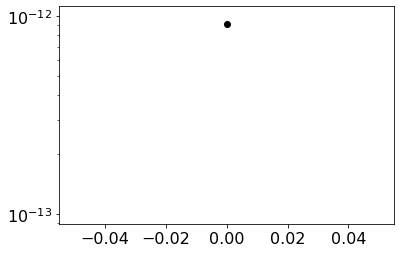

In [181]:
plt.figure()
plt.plot(grb.errors, 'k-o')
plt.yscale('log')

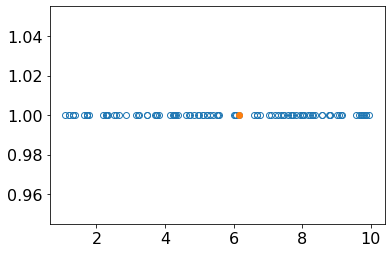

In [182]:
plt.figure()
plt.plot(coords4, np.ones_like(coords4), 'o', fillstyle='none')
plt.plot(coords4[grb.indices], np.ones_like(coords4[grb.indices]), 'o')

In [183]:
grb.validate(ts5_amp)

array([8.19909474e-10, 4.44515535e-11, 1.62799552e-10, 4.83169060e-11,
       6.36646291e-12, 2.06910045e-11, 2.54544830e-10, 4.77484718e-12,
       6.94399205e-10, 4.41445991e-10, 1.87242222e-10, 4.58157956e-11,
       2.27373675e-13, 1.71667125e-11, 7.95807864e-13, 9.09494702e-13,
       2.29078978e-10, 4.34056346e-10, 9.74296199e-11, 4.54747351e-10,
       5.91171556e-12, 1.00726538e-10, 1.29602995e-11, 4.40650183e-10,
       1.15505827e-10, 5.96401151e-10, 8.07744982e-10, 2.11684892e-10,
       4.20641300e-11, 2.58069122e-11, 2.05091055e-10, 9.16884346e-10,
       4.07339940e-10, 3.69936970e-10, 5.09317033e-11, 8.57653504e-10,
       5.45696821e-12, 2.77964318e-10, 9.26547727e-11, 2.17141860e-10,
       7.95807864e-13, 4.16093826e-11, 8.81072992e-11, 4.89990271e-11,
       7.17363946e-11, 8.95852281e-11, 1.41881173e-10, 3.24007488e-11,
       4.88853402e-12, 4.13820089e-10, 1.06865627e-11, 1.43245416e-11,
       2.30443220e-10, 3.95630195e-10, 1.08366294e-09, 1.73940862e-11,
      

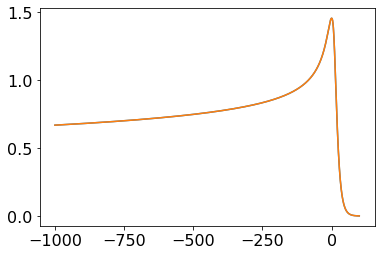

In [184]:
plt.figure()
plt.plot(times, ts5_amp[0])
plt.plot(times, grb.projection_from_basis(ts5_amp[0], grb.basis))

Text(0.5, 0, 'mass-ratio')

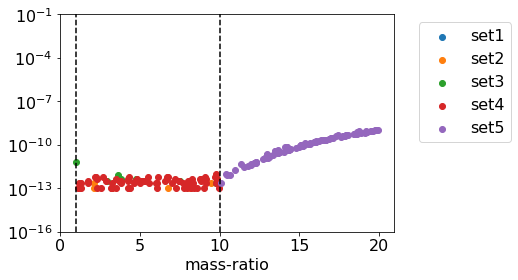

In [197]:
plt.figure()
plt.axvline(coords1[0], ls='--', color='k')
plt.axvline(coords1[1], ls='--', color='k')
plt.scatter(coords1, grb.validate(ts_amp), label='set1')
plt.scatter(coords2, grb.validate(ts2_amp), label='set2')
plt.scatter(coords3, grb.validate(ts3_amp), label='set3')
plt.scatter(coords4, grb.validate(ts4_amp), label='set4')
plt.scatter(coords5, grb.validate(ts5_amp), label='set5')
plt.yscale('log')
plt.ylim(1e-16, 1e-1)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel("mass-ratio")

In [198]:
grb.size

39

In [185]:
# for i, bb in enumerate(grb.basis):
#     plt.figure()
#     plt.plot(times, bb)
#     plt.title(f"basis: {i}")
#     plt.show()
#     plt.close()

In [186]:
final_ts = np.row_stack((step1_training_set, step2_training_set, step3_training_set))

In [187]:
final_ts.shape

(13, 5000)

In [188]:
# by running the greedy algorithm on the final training set
# we can reduce the final basis.
# this removes some of the non-optomalitiy of the
# chunk-based greedy method.
grb_final = GreedyReducedBasis(integration)

In [189]:
grb_final.make(final_ts, 1e-12, 0)


Step 	 Error
1 	 626.824329838654
2 	 2.952149422757657
3 	 0.005875649880408673
4 	 0.0008313683659935123
5 	 3.4365643500677834e-05
6 	 7.705874963903625e-06
7 	 2.03158072054066e-06
8 	 3.764766915992368e-07
9 	 3.874231424561003e-08
10 	 1.240334768226603e-08
11 	 6.59031229588436e-09
12 	 1.5718342183390632e-09
13 	 9.310952009400353e-11


In [190]:
grb_final.errors

array([6.26824330e+02, 2.95214942e+00, 5.87564988e-03, 8.31368366e-04,
       3.43656435e-05, 7.70587496e-06, 2.03158072e-06, 3.76476692e-07,
       3.87423142e-08, 1.24033477e-08, 6.59031230e-09, 1.57183422e-09,
       9.31095201e-11])

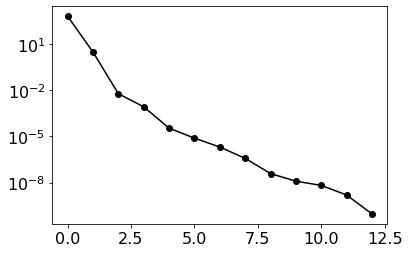

In [191]:
plt.figure()
plt.plot(grb_final.errors, 'k-o')
plt.yscale('log')

Text(0.5, 0, 'mass-ratio')

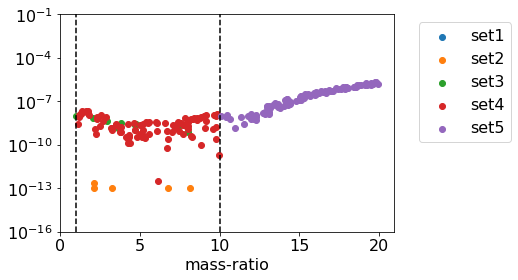

In [192]:
plt.figure()
plt.axvline(coords1[0], ls='--', color='k')
plt.axvline(coords1[1], ls='--', color='k')
plt.scatter(coords1, grb_final.validate(ts_amp), label='set1')
plt.scatter(coords2, grb_final.validate(ts2_amp), label='set2')
plt.scatter(coords3, grb_final.validate(ts3_amp), label='set3')
plt.scatter(coords4, grb_final.validate(ts4_amp), label='set4')
plt.scatter(coords5, grb_final.validate(ts5_amp), label='set5')
plt.yscale('log')
plt.ylim(1e-16, 1e-1)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel("mass-ratio")

In [193]:
grb_final.enrich(ts=ts5_amp, tol=1e-12)


Step 	 Error
0 	 2.060429096673033e-06
1 	 3.049945007660426e-08
2 	 2.418335043330444e-08
3 	 2.1240111891529523e-09
4 	 6.634763849433511e-10
5 	 4.658886609831825e-10
6 	 1.4563283912139013e-10
7 	 6.684786058031023e-11
8 	 6.491518433904275e-11
9 	 5.184119800105691e-11
10 	 1.6484591469634324e-11
11 	 9.549694368615746e-12
12 	 7.16227077646181e-12
13 	 6.252776074688882e-12
14 	 2.5011104298755527e-12
15 	 2.0463630789890885e-12
16 	 1.5916157281026244e-12
17 	 1.2505552149377763e-12
tolerance met. exiting


In [194]:
grb_final.indices

array([54, 71, 85, 70, 26, 15, 47, 74, 14, 32, 19, 12, 73, 76, 44, 83,  4,
       60, 81], dtype=int32)

In [195]:
coords5[grb_final.indices]

array([[19.80045162],
       [18.63372783],
       [16.08626412],
       [19.93872316],
       [18.64960434],
       [10.39288873],
       [13.82254782],
       [14.28749936],
       [10.45030817],
       [17.8398373 ],
       [17.45884059],
       [10.12151935],
       [11.52269439],
       [19.24005567],
       [14.21335707],
       [14.99958888],
       [12.27429699],
       [19.51581368],
       [14.77660545]])

Text(0.5, 0, 'mass-ratio')

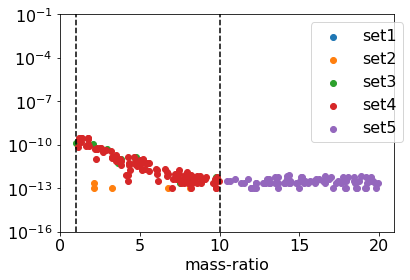

In [196]:
plt.figure()
plt.axvline(coords1[0], ls='--', color='k')
plt.axvline(coords1[1], ls='--', color='k')
plt.scatter(coords1, grb_final.validate(ts_amp), label='set1')
plt.scatter(coords2, grb_final.validate(ts2_amp), label='set2')
plt.scatter(coords3, grb_final.validate(ts3_amp), label='set3')
plt.scatter(coords4, grb_final.validate(ts4_amp), label='set4')
plt.scatter(coords5, grb_final.validate(ts5_amp), label='set5')
# plt.scatter(coords6, grb_final.validate(ts6_amp), label='set6')
plt.yscale('log')
plt.ylim(1e-16, 1e-1)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel("mass-ratio")

In [199]:
grb_final.size

32